In [2]:
import neo
import pylab as plt
import numpy as np
%matplotlib notebook

<IPython.core.display.Javascript object>


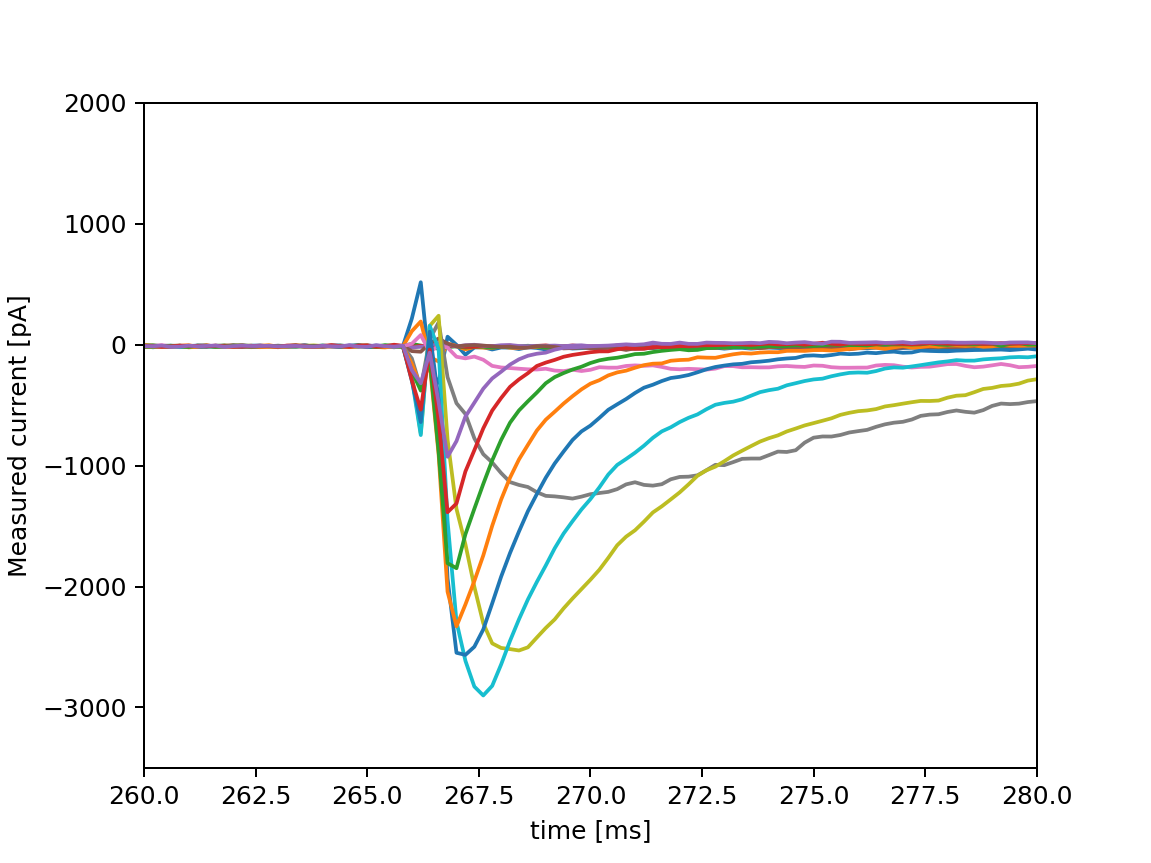

In [3]:
f = neo.io.AxonIO('Active.abf')
bl = f.read_block()
time = np.linspace(0.2, 1000, 5000)

plt.figure()
for idx, seg in enumerate(bl.segments):
    I = np.array(seg.analogsignals[0])
    I = I[:,0]
    plt.plot(time, I); plt.xlabel('time [ms]'); plt.ylabel('Measured current [pA]'); 
    plt.xlim([260, 280]);plt.ylim([-3500, 2000])
plt.show()

<IPython.core.display.Javascript object>


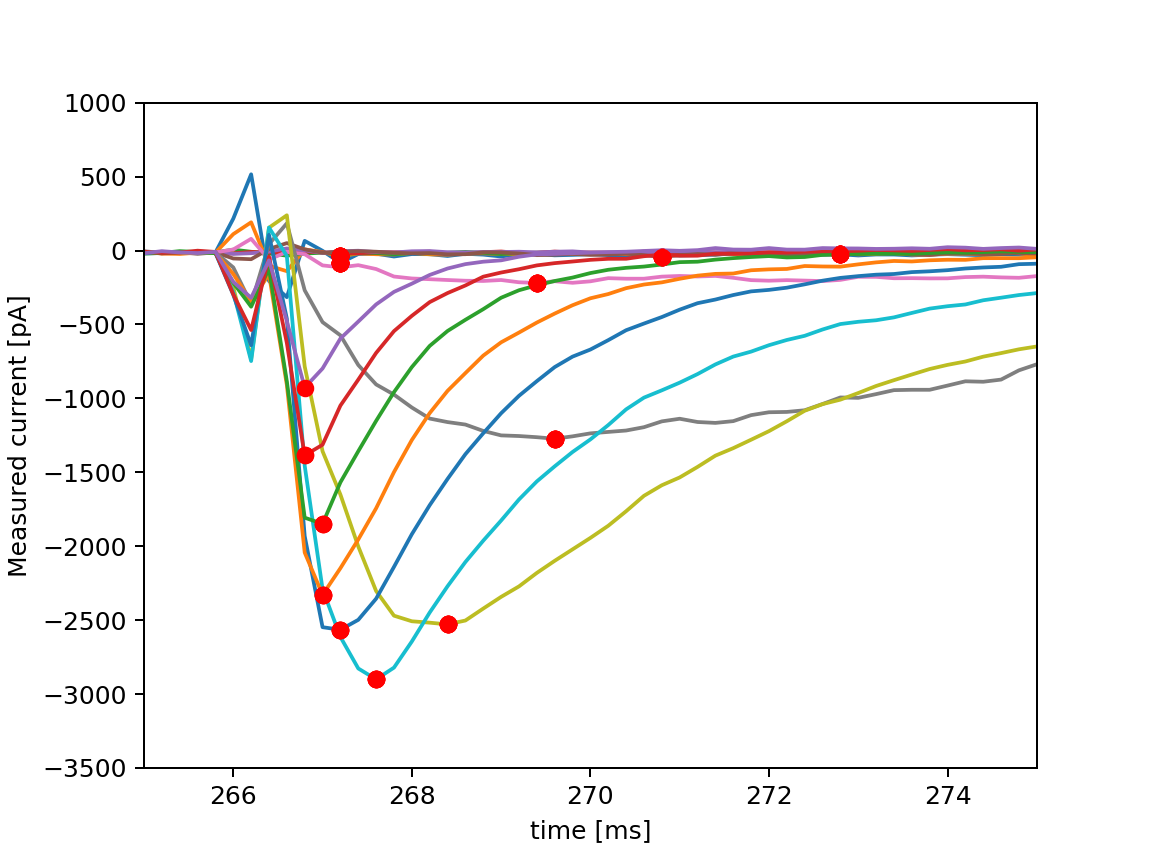

In [4]:
plt.figure()

peak = np.zeros(15)
peak_index = np.zeros(15)
t_peak = np.zeros(15)

# loop to find peaks and store them
for idx, seg in enumerate(bl.segments):
    I = np.array(seg.analogsignals[0])
    I = I[:,0]
    # define a search range for finding the peak inward current
    start = int(5000*(266.6/1000))
    finish = int(1500)
    search = I[start:finish] 
    # find the peak value, its index, and the time at the peak
    peak[idx] = search.min()
    peak_index[idx] = search.argmin()+start
    t_peak[idx] = time[int(peak_index[idx])]
    # plot a close-up of the time-series for each voltage step and the peak you have picked out 
    plt.plot(time, I,t_peak,peak,'ro'); plt.xlabel('time [ms]'); plt.ylabel('Measured current [pA]');
    plt.xlim([265, 275]); plt.ylim([-3500, 1000])
    plt.show()

    

<IPython.core.display.Javascript object>


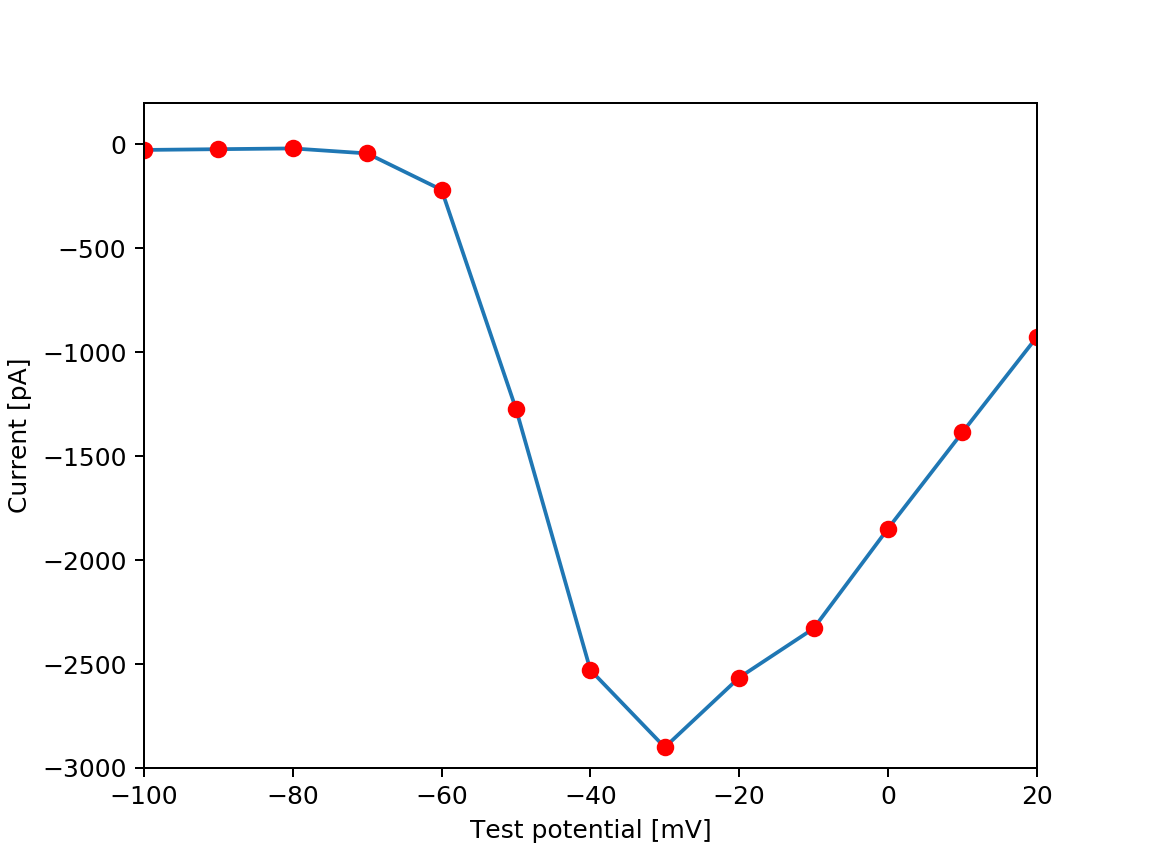

In [5]:
plt.figure()

V_steps = np.linspace(-120, 20, 15)
plt.plot(V_steps, peak,V_steps, peak,'ro'); plt.xlabel('Test potential [mV]'); plt.ylabel('Current [pA]')
plt.xlim([-100, 20])
plt.ylim([-3000, 200])
plt.show()
    
    

<IPython.core.display.Javascript object>


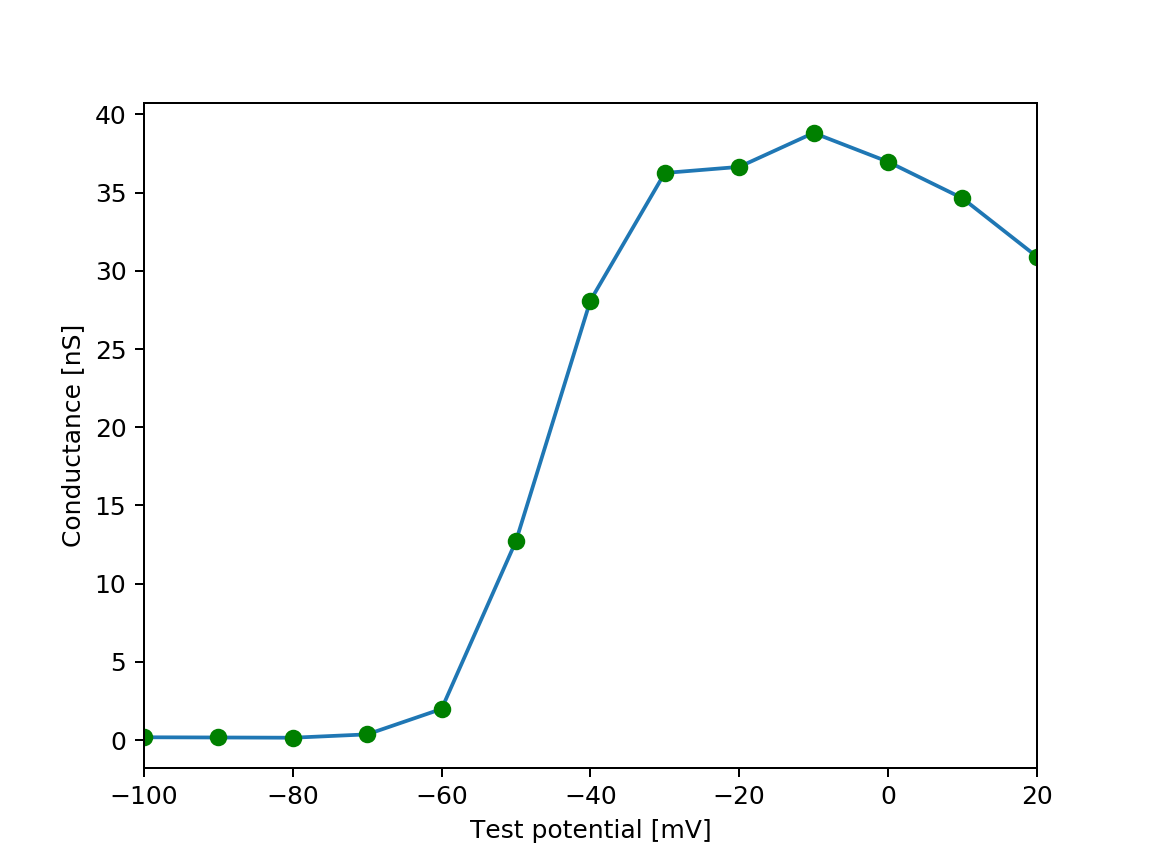

In [6]:
plt.figure()

E_Na = 50 # Nernst 
EC_force = V_steps-E_Na # Electrochemical force (mV)
g_Na = peak/(EC_force) # conductance (nS)
norm_g_Na = g_Na/g_Na.max() # normalized conductance

plt.plot(V_steps,g_Na,V_steps, g_Na,'go'); plt.xlabel('Test potential [mV]'); plt.ylabel('Conductance [nS]')
plt.xlim([-100, 20])
#plt.ylim([-0.10, 1.1])

plt.show()

<IPython.core.display.Javascript object>


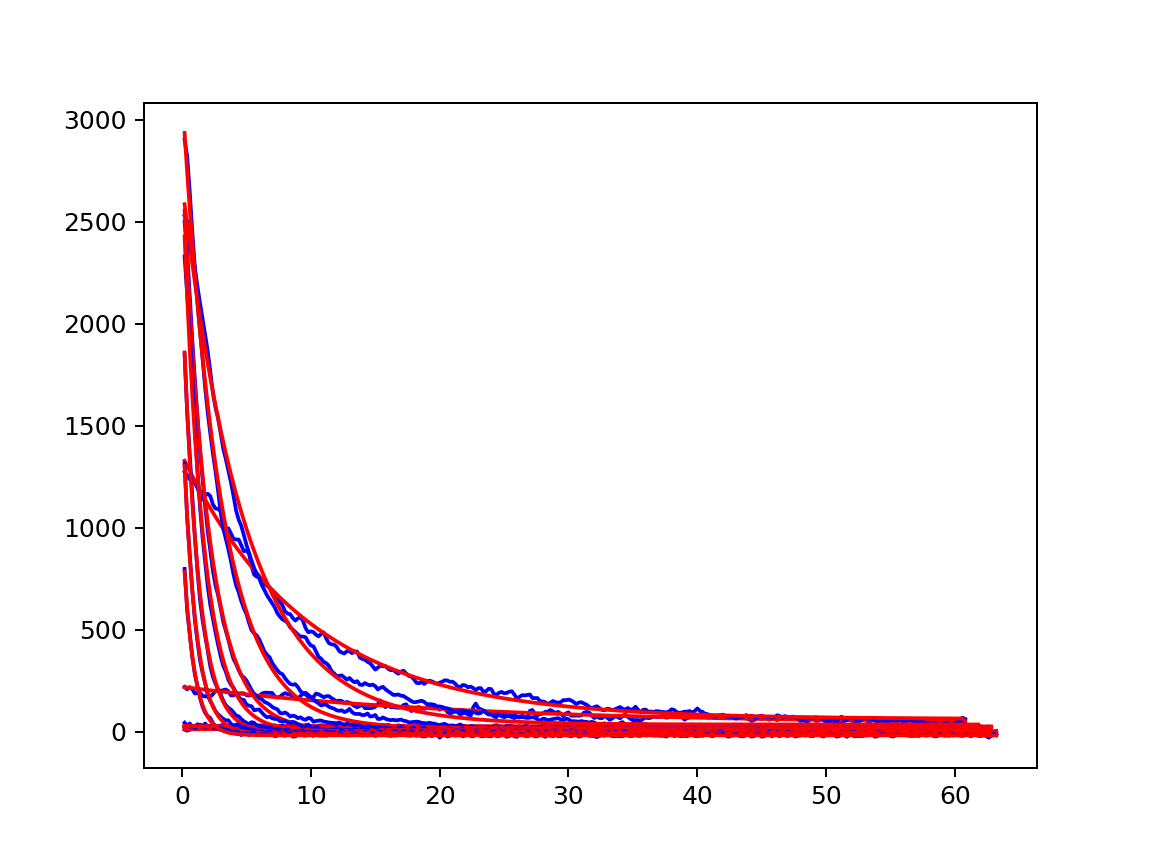

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in multiply
  import sys


<IPython.core.display.Javascript object>


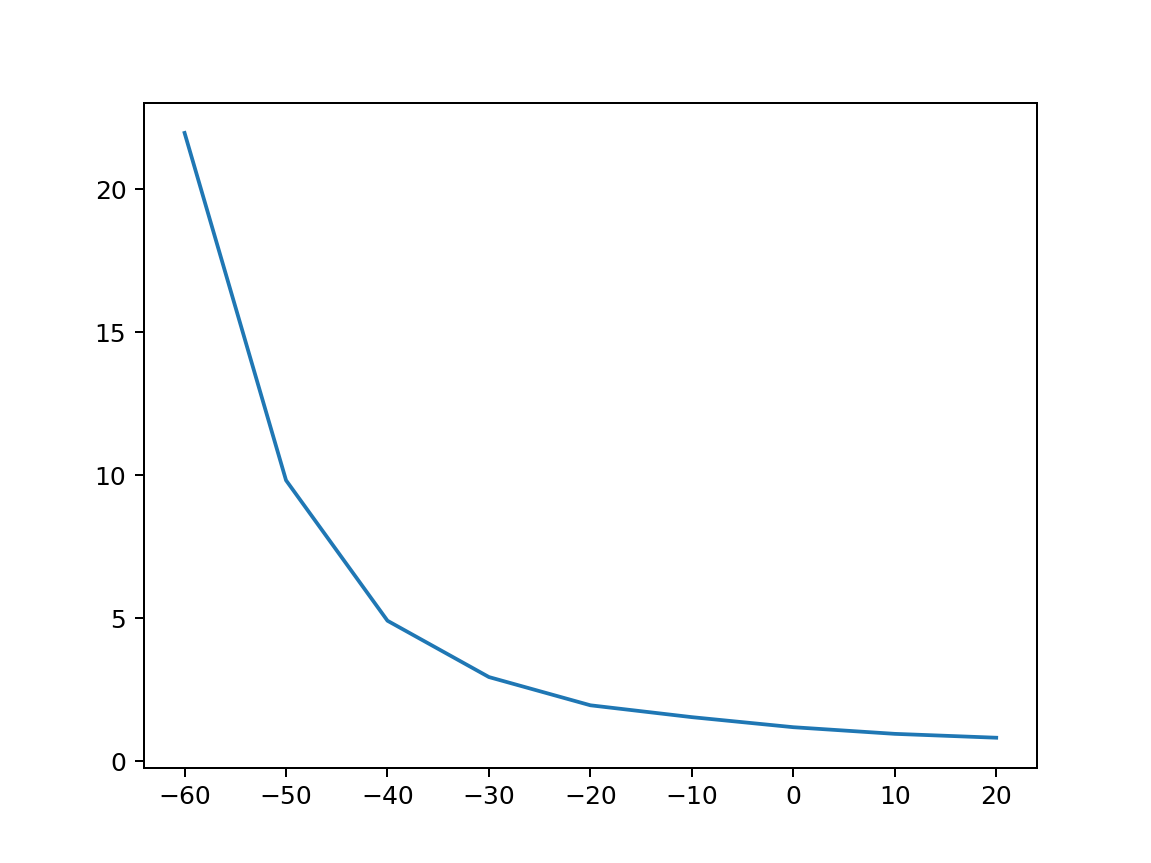

In [7]:
from scipy.optimize import curve_fit

tau = np.zeros(15)

# define the decay function to this data range
def exp_decay(t,A,K,C): 
    return np.array(A * np.exp(-K * t) + C)
def exp_fit(t,y): 
    params, cov = curve_fit(exp_decay, t, y)
    A, K, C = params
    return A, K, C

plt.figure()
# loop to find decay constants and store them
for idx, seg in enumerate(bl.segments):
    I = np.array(seg.analogsignals[0])
    I = I[:,0]
    
    # define the range for inactivation fitting
    start = int(5000*(t_peak[idx]/1000))
    finish = int(5000*(330/1000))
    short_I = 0-I[start:finish]
    short_t = time[start:finish]-time[start-1]
    
    # fit the exponential decay function
    A, K, C = exp_fit(short_t,short_I)
    
    # plot the data
    plt.plot(short_t, short_I,'b')
    
    # plot the fits
    fit_I = exp_decay(short_t,A,K,C)
    plt.plot(short_t, fit_I,'r')
    
    # store the time constants
    tau[idx] = 1/K
plt.show()
plt.figure()
plt.plot(V_steps[6:], tau[6:])

In [8]:
import pandas as pd
out = pd.DataFrame({'Voltage':V_steps,'Peak_INa':peak,'Tau_inact':tau})
out.to_csv('Act_table.csv')